In [2]:
import xarray as xr
from xarray.coders import CFDatetimeCoder
import numpy as np
import os
import warnings
from dask.diagnostics import ProgressBar
from slepy import SLECalculator
from pathlib import Path
import matplotlib.pyplot as plt

In [12]:
filepath = '/Volumes/LaCie/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg/ssp126/r1i1p1f1/Omon/thetao/gn/v20221112/thetao_Omon_EC-Earth3-Veg_ssp126_r1i1p1f1_gn_201501-201512.nc'
ds = xr.open_dataset(filepath)
ds

<xarray.Dataset> Size: 389MB
Dimensions:             (time: 12, bnds: 2, lev: 75, j: 292, i: 362, vertices: 4)
Coordinates:
  * time                (time) datetime64[ns] 96B 2015-01-16T12:00:00 ... 201...
  * lev                 (lev) float64 600B 0.5058 1.556 ... 5.698e+03 5.902e+03
  * j                   (j) int32 1kB 1 2 3 4 5 6 7 ... 287 288 289 290 291 292
  * i                   (i) int32 1kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362
    latitude            (j, i) float64 846kB ...
    longitude           (j, i) float64 846kB ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 192B ...
    lev_bnds            (lev, bnds) float64 1kB ...
    vertices_latitude   (j, i, vertices) float64 3MB ...
    vertices_longitude  (j, i, vertices) float64 3MB ...
    thetao              (time, lev, j, i) float32 381MB ...
Attributes: (12/46)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        ScenarioMIP
    branch_method:                      standard
    branch_time_in_child:               60265.0
    branch_time_in_parent:              60265.0
    contact:                            cmip6-data@ec-earth.org
    ...                                 ...
    variant_label:                      r1i1p1f1
    license:                            CMIP6 model data produced by EC-Earth...
    cmor_version:                       3.4.0
    tracking_id:                        hdl:21.14100/05072b23-e23f-434e-adb8-...
    history:                            2019-06-28T09:06:01Z ; CMOR rewrote d...
    latest_applied_cmor_fixer_version:  v3.0

In [3]:
def create_time_bnds(ds: Dataset):
    """Creates time bounds for a dataset with 'time' dimension"""
    time_bnds = np.zeros((ds.sizes['time'], ds.sizes['bnds']))
    time_bnds[:, 0] = ds.time.values
    time_bnds[:, 1] = ds.time.values + 365
    return time_bnds

def decode_vars(ds: Dataset, *varnames: str):
    """Decodes time and bnds from int to datetime using CFDatetimeCoder"""
    def _decode(varname):
        var = ds.variables[varname]
        return coder.decode(var, var.attrs)

    coder = CFDatetimeCoder(use_cftime=True)
    return [_decode(varname) for varname in varnames]

def year_to_cftime(ds_in: Dataset) -> Dataset:
    """Relabel time axis from year ints to cftime objects"""

    # convert from years to time (in days)
    ds = ds_in.rename({'year': 'time'})
    ds['time'] = ds_in.year.values*365.

    # set attributes for decoder
    attrs = {
        "units": "days since 0000-01-01 00:00:00",
        "calendar": "noleap",
    }
    ds.time.attrs.update(attrs)

    # create time bounds
    timeBounds = create_time_bnds(ds)
    ds['time_bnds'] = (('time', 'bnds'), timeBounds)
    ds.time_bnds.attrs.update(attrs)

    # decode using CFDatetimeCoder
    time, bnds = decode_vars(ds, 'time', 'time_bnds')
    ds_out = ds.assign_coords(time=time, time_bnds=bnds)

    return ds_out

def crop_to_48S(ds: Dataset, lonname, latname) -> Dataset:
    """Crops the dataset to latitudes below 48S."""
    #print('cropping dataset to 48S')
    minLat = ds.lat.min(dim=lonname)
    mask = minLat <= -48.
    yIndices = np.nonzero(mask.values)[0]
    return ds.isel({latname: yIndices})

def convert_lev(ds_in: Dataset) -> Dataset:
    """Convert pressure levels from cm to m."""
    ds = xr.Dataset()
    # copy temperature and/or salinity
    for var in ['so', 'thetao']:
        if var in ds_in:
            ds[var] = ds_in[var]
    
    # convert lev coordinates
    ds.coords['lev'] = 0.01 * ds_in.coords['lev']
    ds.lev.attrs['units'] = 'm'
    ds.lev.attrs['bounds'] = 'lev_bnds'

    # convert lev_bnds
    lev_bnds = ds_in.lev_bnds.values
    ds.coords['lev_bnds'] = (('lev', 'bnds'), lev_bnds)
    ds.lev_bnds.attrs['units'] = 'm'

    return ds

In [5]:
def compute_yearly_mean(inFileName: str, outFileName: str) -> None:
    """Crop to below 48 S and take annual mean over the data."""

    # If the outfile already exists, skip
    if os.path.exists(outFileName):
        return

    print('{} to {}'.format(inFileName, outFileName))

    # convert lev into m
    coder = CFDatetimeCoder(use_cftime=True)

    dsIn = xr.open_dataset(inFileName, decode_times=coder)
    dsIn = crop_to_48S(dsIn)
    dsIn = dsIn.rename({'d2': 'bnds'})
    ds = convert_lev(dsIn)


    chunks = {'time': 24}
    ds = ds.chunk(chunks)
    # annual mean
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        ds = ds.groupby('time.year').mean('time', keep_attrs=True)

    with ProgressBar():
        ds = ds.compute()

    # convert back to CF-compliant time
    print('converting to cftime')
    ds = year_to_cftime(ds)

    print('saving final netcdf')
    encoding = {'time': {'units': 'days since 0000-01-01'}}
    ds.to_netcdf(outFileName, encoding=encoding)

In [ ]:
coder = CFDatetimeCoder(use_cftime=True)
ds = xr.open_dataset(filepath)
ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
ds = crop_to_48S(ds, 'i', 'j')
ds = ds.chunk({'time': 1})
mean = ds.groupby('time.year').mean('time', keep_attrs=True)
with ProgressBar():
    mean = mean.compute()

[########################################] | 100% Completed | 837.68 ms


In [20]:
withtime = year_to_cftime(mean)
withtime

<xarray.Dataset> Size: 11MB
Dimensions:             (time: 1, lev: 75, bnds: 2, j: 77, i: 362, vertices: 4)
Coordinates:
  * lev                 (lev) float64 600B 0.5058 1.556 ... 5.698e+03 5.902e+03
  * j                   (j) int32 308B 1 2 3 4 5 6 7 8 ... 71 72 73 74 75 76 77
  * i                   (i) int32 1kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362
    lat                 (j, i) float64 223kB -78.39 -78.39 ... -48.09 -48.09
    lon                 (j, i) float64 223kB 72.5 73.5 74.5 ... 71.5 72.5 73.5
    time_bnds           (time, bnds) object 16B ...
  * time                (time) object 8B 2015-01-01 00:00:00
Dimensions without coordinates: bnds, vertices
Data variables:
    lev_bnds            (time, lev, bnds) float64 1kB 0.0 1.024 ... 6.004e+03
    vertices_latitude   (time, j, i, vertices) float64 892kB -78.39 ... -47.76
    vertices_longitude  (time, j, i, vertices) float64 892kB 72.5 72.5 ... 73.0
    thetao              (time, lev, j, i) float32 8MB nan nan nan ... nan nan
Attributes: (12/46)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        ScenarioMIP
    branch_method:                      standard
    branch_time_in_child:               60265.0
    branch_time_in_parent:              60265.0
    contact:                            cmip6-data@ec-earth.org
    ...                                 ...
    variant_label:                      r1i1p1f1
    license:                            CMIP6 model data produced by EC-Earth...
    cmor_version:                       3.4.0
    tracking_id:                        hdl:21.14100/05072b23-e23f-434e-adb8-...
    history:                            2019-06-28T09:06:01Z ; CMOR rewrote d...
    latest_applied_cmor_fixer_version:  v3.0

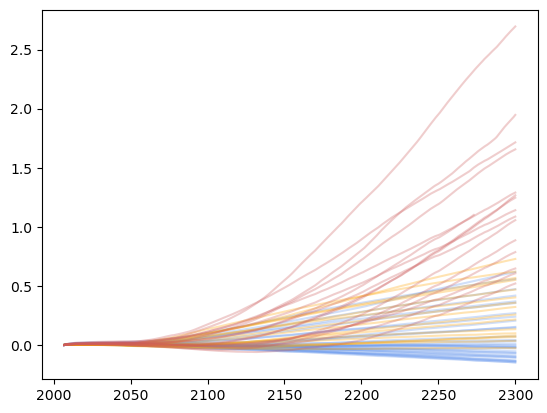

In [4]:
ssp126 = xr.open_dataset('/Users/jonniebarnsley/Downloads/ssp126_sle.nc')
ssp534 = xr.open_dataset('/Users/jonniebarnsley/Downloads/ssp534-over_sle.nc')
ssp585 = xr.open_dataset('/Users/jonniebarnsley/Downloads/ssp585_sle.nc')


def plot_sle(ds, col='black'):
    for run in ds.run:
        plt.plot(ds.time, ds.sle.sel(run=run), color=col, alpha=0.3)

plot_sle(ssp126, 'cornflowerblue')
plot_sle(ssp534, 'orange')
plot_sle(ssp585, 'indianred')

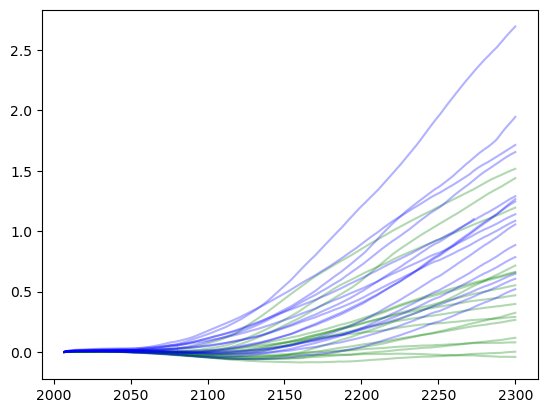

In [12]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/ssp585_sle.nc')
cesm = file.sel(run=slice(1, 16))
mri = file.sel(run=slice(17, 32))
for run in mri.run:
    plt.plot(mri.time, mri.sle.sel(run=run), color='green', alpha=0.3)
for run in cesm.run:
    plt.plot(cesm.time, cesm.sle.sel(run=run), color='blue', alpha=0.3) 

/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_51180/1514009744.py:1: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  file = xr.open_dataset('/Users/jonniebarnsley/Downloads/thermal_forcing_EC-Earth3-Veg_ssp126_8km_2300.nc')
/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_51180/1514009744.py:2: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  file.thermal_forcing_0010.plot()


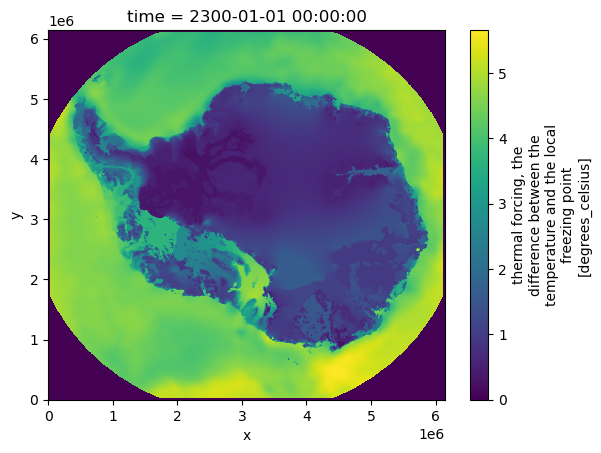

In [5]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/thermal_forcing_EC-Earth3-Veg_ssp126_8km_2300.nc')
file.thermal_forcing_0010.plot()

In [6]:
path = Path('/Users/jonniebarnsley/Downloads/ec-earth_tf_330m')
files = sorted(path.glob('*.nc'))
ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
ds

/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_51180/3477392045.py:3: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_51180/3477392045.py:3: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_51180/3477392045.py:3: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing 

<xarray.Dataset> Size: 1GB
Dimensions:               (time: 306, y: 768, x: 768)
Coordinates:
  * time                  (time) object 2kB 1995-01-01 00:00:00 ... 2300-01-0...
  * x                     (x) float64 6kB 4e+03 1.2e+04 ... 6.132e+06 6.14e+06
  * y                     (y) float64 6kB 4e+03 1.2e+04 ... 6.132e+06 6.14e+06
Data variables:
    thermal_forcing_0005  (time, y, x) float64 1GB dask.array<chunksize=(1, 768, 768), meta=np.ndarray>
Attributes:
    history:  Sun Jan 11 17:50:27 2026: ncks -v thermal_forcing_0005 bisicles...
    NCO:      netCDF Operators version 5.1.6 (Homepage = http://nco.sf.net, C...

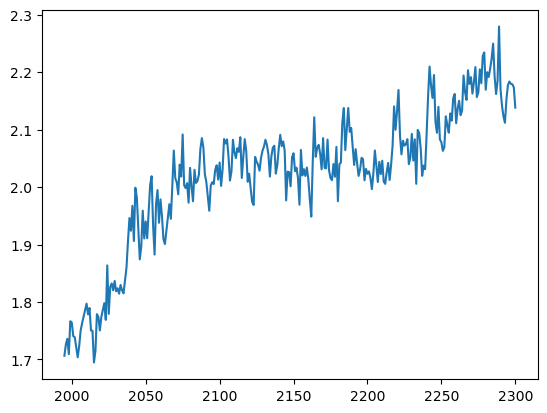

In [8]:
ts = ds.mean(dim=['x', 'y'])
years = range(1995, 2301)
plt.plot(years, ts.thermal_forcing_0005)

/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_51180/33812832.py:3: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_51180/33812832.py:3: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_51180/33812832.py:3: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using 

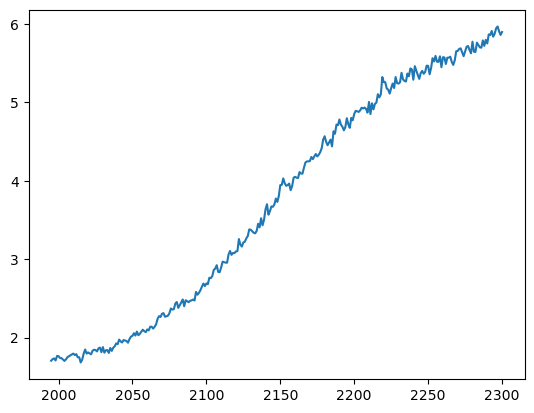

In [15]:
path = Path('/Users/jonniebarnsley/Downloads/ec-earth-330m-tf')
files = sorted(path.glob('*.nc'))
ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
ts = ds.mean(dim=['x', 'y'])
years = range(1995, 2301)
plt.plot(years, ts.thermal_forcing_0005)

In [9]:
vars = ['thermal_forcing_{:04d}'.format(i) for i in range(30)]
print(" ".join(vars))

thermal_forcing_0000 thermal_forcing_0001 thermal_forcing_0002 thermal_forcing_0003 thermal_forcing_0004 thermal_forcing_0005 thermal_forcing_0006 thermal_forcing_0007 thermal_forcing_0008 thermal_forcing_0009 thermal_forcing_0010 thermal_forcing_0011 thermal_forcing_0012 thermal_forcing_0013 thermal_forcing_0014 thermal_forcing_0015 thermal_forcing_0016 thermal_forcing_0017 thermal_forcing_0018 thermal_forcing_0019 thermal_forcing_0020 thermal_forcing_0021 thermal_forcing_0022 thermal_forcing_0023 thermal_forcing_0024 thermal_forcing_0025 thermal_forcing_0026 thermal_forcing_0027 thermal_forcing_0028 thermal_forcing_0029


/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_51180/2797100196.py:1: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  file = xr.open_dataset('/Users/jonniebarnsley/Downloads/thermal_forcing_EC-Earth3-Veg_ssp585_8km_2300.nc')
/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_51180/2797100196.py:2: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  file.thermal_forcing_0010.plot()


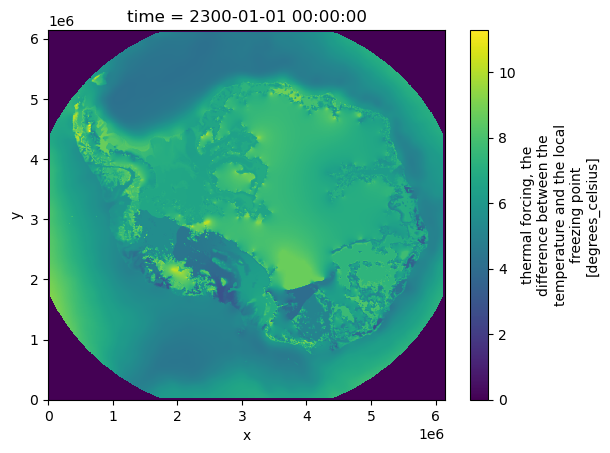

In [21]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/thermal_forcing_EC-Earth3-Veg_ssp585_8km_2300.nc')
file.thermal_forcing_0010.plot()

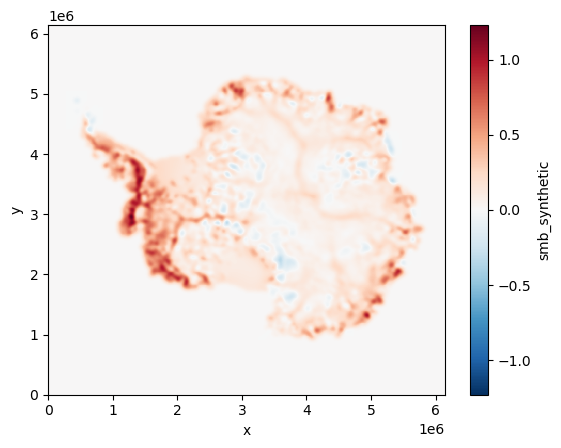

In [25]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/ppe_run001_synthetic_smb.nc')
file.smb_synthetic.plot()

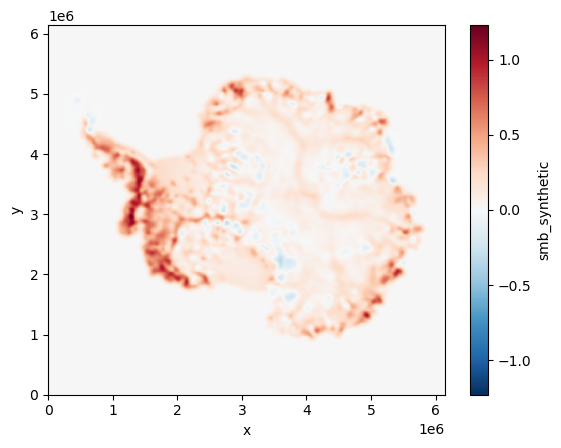

In [27]:
test = xr.open_dataset('/Users/jonniebarnsley/Downloads/synth_smb_test.nc')
test.smb_synthetic.plot()

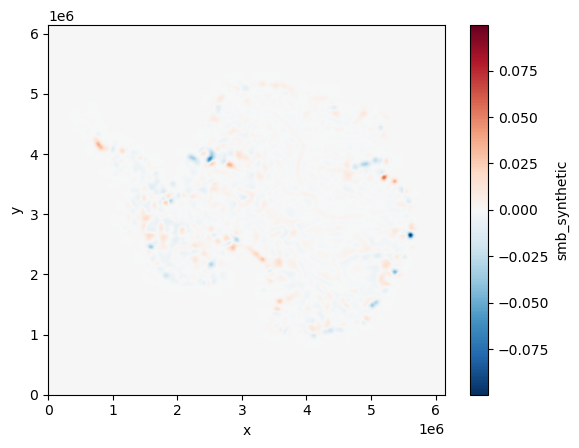

In [28]:
(file.smb_synthetic - test.smb_synthetic).plot()

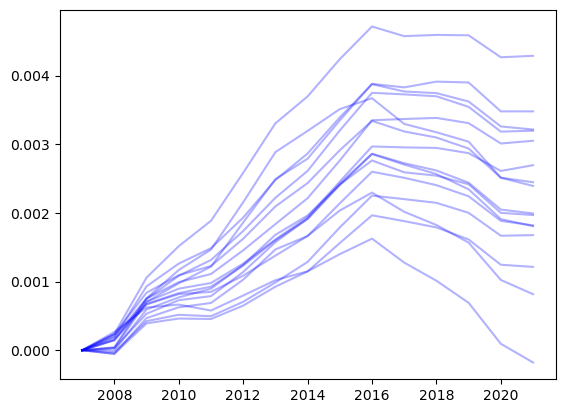

In [3]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/ssp126_ec-earth_sle_2100.nc')
for run in file.run:
    plt.plot(file.time, file.sle.sel(run=run), color='blue', alpha=0.3)

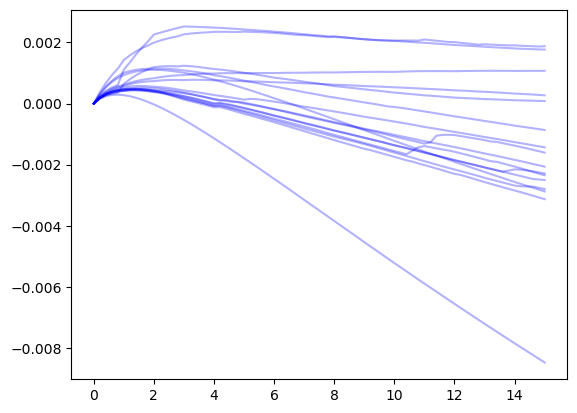

In [5]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/inv_sle.nc')
file = file.sel(run=slice(33, 48))
for run in file.run:
    plt.plot(file.time, file.sle.sel(run=run), color='blue', alpha=0.3)